## Setup

In [ ]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import gc

from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from fastkde.fastKDE import fastKDE
from scipy.stats import linregress
from scipy.signal import butter, filtfilt
from scipy.signal import correlate
from scipy.stats import pearsonr

from harp_resources import process, utils
from sleap import load_and_process as lp

# symbols to use ✅ ℹ️ ⚠️ ❗

In [ ]:
# set up variables and load data 
############################################################################################################

plot_timeseries = False
score_cutoff = 0.2 # for checking prediction accuracy
outlier_sd_threshold = 10 # for removing outliers from the data
NaNs_removed = False # for checking if NaNs already removed in the notebook
cutoff = 10  # Hz for pupil diameter filtering 

# for saccades
framerate = 59.77  # Hz (in the future, should come from saved data)
threshold = 65  # px/s FIXME make this adaptive
refractory_period = pd.Timedelta(milliseconds=100)  # msec, using pd.Timedelta for datetime index
plot_saccade_detection_QC = True

data_path = Path('/Users/rancze/Documents/Data/vestVR/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2782-2025-04-28T14-22-03') 
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/No_iso_correction/Visual_mismatch_day3/B6J2717-2024-12-10T12-17-03') # sleap data 2 is duplicate of sleap data 1
save_path = data_path.parent / f"{data_path.name}_processedData"


print ("\n❗ 20251025 NOT sure I understand this Ede ---- if SleapData.csv was already saved in the VideoData folder, this may break. Delete the file if you want to rerun processing\n")
VideoData1, VideoData2, VideoData1_Has_Sleap, VideoData2_Has_Sleap = lp.load_videography_data(data_path)

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

if VideoData1_Has_Sleap:
    VideoData1 = VideoData1.drop(columns=['track']) # drop the track column as it is empty
    coordinates_dict1_raw=lp.get_coordinates_dict(VideoData1, columns_of_interest)
    FPS_1 = 1 / VideoData1["Seconds"].diff().mean()  # frame rate for VideoData1 TODO where to save it, is it useful?
    print(f"FPS_1: {FPS_1}")

if VideoData2_Has_Sleap:
    VideoData2 = VideoData2.drop(columns=['track']) # drop the track column as it is empty
    coordinates_dict2_raw=lp.get_coordinates_dict(VideoData2, columns_of_interest)
    FPS_2 = 1 / VideoData2["Seconds"].diff().mean()  # frame rate for VideoData2
    print(f"FPS_2: {FPS_2}")


In [ ]:
# plot timeseries of coordinates in browser for both VideoData1 and VideoData2
############################################################################################################
if plot_timeseries:
    print(f'⚠️ Check for long discontinuities and outliers in the data, we will try to deal with them later')
    print(f'ℹ️ Figures open in browser window, takes a bit of time.')

    # Helper list variables
    subplot_titles = (
        "X coordinates for pupil centre and left-right eye corner",
        "Y coordinates for pupil centre and left-right eye corner",
        "X coordinates for iris points",
        "Y coordinates for iris points"
    )
    eye_x = ['left.x', 'center.x', 'right.x']
    eye_y = ['left.y', 'center.y', 'right.y']
    iris_x = ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']
    iris_y = ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']

    # --- VideoData1 ---
    if VideoData1_Has_Sleap:
        fig1 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=subplot_titles
        )

        # Row 1: left.x, center.x, right.x
        for col in eye_x:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=1, col=1)
        # Row 2: left.y, center.y, right.y
        for col in eye_y:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=2, col=1)
        # Row 3: p1.x ... p8.x
        for col in iris_x:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=3, col=1)
        # Row 4: p1.y ... p8.y
        for col in iris_y:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=4, col=1)

        fig1.update_layout(
            height=1200,
            title_text="Time series subplots for coordinates [VideoData1]",
            showlegend=True
        )
        fig1.update_xaxes(title_text="Seconds", row=4, col=1)
        fig1.update_yaxes(title_text="X Position", row=1, col=1)
        fig1.update_yaxes(title_text="Y Position", row=2, col=1)
        fig1.update_yaxes(title_text="X Position", row=3, col=1)
        fig1.update_yaxes(title_text="Y Position", row=4, col=1)

        fig1.show(renderer='browser')

    # --- VideoData2 ---
    if VideoData2_Has_Sleap:
        fig2 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=subplot_titles
        )
        # Row 1: left.x, center.x, right.x
        for col in eye_x:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=1, col=1)
        # Row 2: left.y, center.y, right.y
        for col in eye_y:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=2, col=1)
        # Row 3: p1.x ... p8.x
        for col in iris_x:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=3, col=1)
        # Row 4: p1.y ... p8.y
        for col in iris_y:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=4, col=1)

        fig2.update_layout(
            height=1200,
            title_text="Time series subplots for coordinates [VideoData2]",
            showlegend=True
        )
        fig2.update_xaxes(title_text="Seconds", row=4, col=1)
        fig2.update_yaxes(title_text="X Position", row=1, col=1)
        fig2.update_yaxes(title_text="Y Position", row=2, col=1)
        fig2.update_yaxes(title_text="X Position", row=3, col=1)
        fig2.update_yaxes(title_text="Y Position", row=4, col=1)

        fig2.show(renderer='browser')

In [ ]:
# QC plot XY coordinate distributions to visualize outliers 
############################################################################################################

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

# Filter out NaN values and calculate the min and max values for X and Y coordinates for both dict1 and dict2

def min_max_dict(coordinates_dict):
    x_min = min([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].min() for col in columns_of_interest])
    x_max = max([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].max() for col in columns_of_interest])
    y_min = min([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].min() for col in columns_of_interest])
    y_max = max([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].max() for col in columns_of_interest])
    return x_min, x_max, y_min, y_max

# Only plot panels for 1 and 2 if VideoData1_Has_Sleap and/or VideoData2_Has_Sleap are true

# Compute min/max as before for global axes limits
x_min1, x_max1, y_min1, y_max1 = min_max_dict(coordinates_dict1_raw)
x_min2, x_max2, y_min2, y_max2 = min_max_dict(coordinates_dict2_raw)

# Use global min and max for consistency across subplots
x_min = min(x_min1, x_min2)
x_max = max(x_max1, x_max2)
y_min = min(y_min1, y_min2)
y_max = max(y_max1, y_max2)

# Create the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('XY coordinate distribution of different points for VideoData1 (_dict1) and VideoData2 (_dict2) before outlier removal and NaN interpolation', fontsize=14)

# Define colormap for p1-p8
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

# Panel 1: left, right, center (dict1)
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    ax[0, 0].set_title('VideoData1 (_dict1): left, right, center')
    ax[0, 0].scatter(coordinates_dict1_raw['left.x'], coordinates_dict1_raw['left.y'], color='black', label='left', s=10)
    ax[0, 0].scatter(coordinates_dict1_raw['right.x'], coordinates_dict1_raw['right.y'], color='grey', label='right', s=10)
    ax[0, 0].scatter(coordinates_dict1_raw['center.x'], coordinates_dict1_raw['center.y'], color='red', label='center', s=10)
    ax[0, 0].set_xlim([x_min, x_max])
    ax[0, 0].set_ylim([y_min, y_max])
    ax[0, 0].set_xlabel('x coordinates (pixels)')
    ax[0, 0].set_ylabel('y coordinates (pixels)')
    ax[0, 0].legend(loc='upper right')
else:
    ax[0, 0].axis('off')

# Panel 2: p1 to p8 (dict1)
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    ax[0, 1].set_title('VideoData1 (_dict1): p1 to p8')
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[0, 1].scatter(coordinates_dict1_raw[f'{col}.x'], coordinates_dict1_raw[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[0, 1].set_xlim([x_min, x_max])
    ax[0, 1].set_ylim([y_min, y_max])
    ax[0, 1].set_xlabel('x coordinates (pixels)')
    ax[0, 1].set_ylabel('y coordinates (pixels)')
    ax[0, 1].legend(loc='upper right')
else:
    ax[0, 1].axis('off')

# Panel 3: left, right, center (dict2)
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    ax[1, 0].set_title('VideoData2 (_dict2): left, right, center')
    ax[1, 0].scatter(coordinates_dict2_raw['left.x'], coordinates_dict2_raw['left.y'], color='black', label='left', s=10)
    ax[1, 0].scatter(coordinates_dict2_raw['right.x'], coordinates_dict2_raw['right.y'], color='grey', label='right', s=10)
    ax[1, 0].scatter(coordinates_dict2_raw['center.x'], coordinates_dict2_raw['center.y'], color='red', label='center', s=10)
    ax[1, 0].set_xlim([x_min, x_max])
    ax[1, 0].set_ylim([y_min, y_max])
    ax[1, 0].set_xlabel('x coordinates (pixels)')
    ax[1, 0].set_ylabel('y coordinates (pixels)')
    ax[1, 0].legend(loc='upper right')
else:
    ax[1, 0].axis('off')

# Panel 4: p1 to p8 (dict2)
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    ax[1, 1].set_title('VideoData2 (_dict2): p1 to p8')
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[1, 1].scatter(coordinates_dict2_raw[f'{col}.x'], coordinates_dict2_raw[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[1, 1].set_xlim([x_min, x_max])
    ax[1, 1].set_ylim([y_min, y_max])
    ax[1, 1].set_xlabel('x coordinates (pixels)')
    ax[1, 1].set_ylabel('y coordinates (pixels)')
    ax[1, 1].legend(loc='upper right')
else:
    ax[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


In [ ]:
# QC for consecutive NaN and low confidence inference frames TODO - not sure what to do, what threshold to use to send it back to SLEAP inference 
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

# VideoData1 NaN analysis
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    all_nan_df = VideoData1[VideoData1[columns_of_interest].isnull().all(1)]
    all_nan_index_array = all_nan_df.index.values

    # print the groups of sequential NaNs
    group_counts = {'1-5': 0, '6-10': 0, '>10': 0}
    i = 1
    for group in lp.find_sequential_groups(all_nan_index_array):
        #print(f'NaN frame group {i} with {len(group)} elements')
        if 1 <= len(group) <= 5:
            group_counts['1-5'] += 1
        elif 6 <= len(group) <= 10:
            group_counts['6-10'] += 1
        else:
            group_counts['>10'] += 1
            print(f'\n⚠️ VideoData1 Framegroup {i} has {len(group)} consecutive all NaN frames  with indices {group}. If this is a long group, consider rerunning SLEAP inference.')
        i += 1

    print(f"\nVideoData1 - Framegroups with 1-5 consecutive all NaN frames: {group_counts['1-5']}")
    print(f"VideoData1 - Framegroups with 6-10 consecutive all NaN frames: {group_counts['6-10']}")
    print(f"VideoData1 - Framegroups with >10 consecutive all NaN frames: {group_counts['>10']}")

# VideoData2 NaN analysis
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    all_nan_df2 = VideoData2[VideoData2[columns_of_interest].isnull().all(1)]
    all_nan_index_array2 = all_nan_df2.index.values

    # print the groups of sequential NaNs for VideoData2
    group_counts2 = {'1-5': 0, '6-10': 0, '>10': 0}
    i = 1
    for group in lp.find_sequential_groups(all_nan_index_array2):
        #print(f'NaN frame group {i} with {len(group)} elements')
        if 1 <= len(group) <= 5:
            group_counts2['1-5'] += 1
        elif 6 <= len(group) <= 10:
            group_counts2['6-10'] += 1
        else:
            group_counts2['>10'] += 1
            print(f'\n⚠️ VideoData2 Framegroup {i} has {len(group)} consecutive all NaN frames  with indices {group}. If this is a long group, consider rerunning SLEAP inference.')
        i += 1

    print(f"\nVideoData2 - Framegroups with 1-5 consecutive all NaN frames: {group_counts2['1-5']}")
    print(f"VideoData2 - Framegroups with 6-10 consecutive all NaN frames: {group_counts2['6-10']}")
    print(f"VideoData2 - Framegroups with >10 consecutive all NaN frames: {group_counts2['>10']}")

############################################################################################################
# check if we can use some filtering on scores to remove bad frames
############################################################################################################

score_cutoff = 0.2
columns_of_interest = ['left.score','center.score','right.score','p1.score','p2.score','p3.score','p4.score','p5.score','p6.score','p7.score','p8.score']

# VideoData1 confidence score analysis
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    total_points1 = len(VideoData1)
    print(f'\nℹ️ VideoData1 - Top 3 columns with most frames below {score_cutoff} confidence score:')

    # Calculate statistics for all columns
    video1_stats = []
    for col in columns_of_interest:
        count_below_threshold = (VideoData1[col] < score_cutoff).sum()
        percentage_below_threshold = (count_below_threshold / total_points1) * 100

        # Find the longest consecutive series below threshold
        below_threshold = VideoData1[col] < score_cutoff
        longest_series = 0
        current_series = 0

        for value in below_threshold:
            if value:
                current_series += 1
                if current_series > longest_series:
                    longest_series = current_series
            else:
                current_series = 0

        video1_stats.append((col, count_below_threshold, percentage_below_threshold, longest_series))

    # Sort by count_below_threshold and show top 3
    video1_stats.sort(key=lambda x: x[1], reverse=True)
    for i, (col, count, percentage, longest) in enumerate(video1_stats[:3]):
        print(f"VideoData1 - #{i+1}: {col} | Values below {score_cutoff}: {count} ({percentage:.2f}%) | Longest consecutive frame series: {longest}")

# VideoData2 confidence score analysis
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    total_points2 = len(VideoData2)
    print(f'\nℹ️ VideoData2 - Top 3 columns with most frames below {score_cutoff} confidence score:')

    # Calculate statistics for all columns
    video2_stats = []
    for col in columns_of_interest:
        count_below_threshold = (VideoData2[col] < score_cutoff).sum()
        percentage_below_threshold = (count_below_threshold / total_points2) * 100
        
        # Find the longest consecutive series below threshold
        below_threshold = VideoData2[col] < score_cutoff
        longest_series = 0
        current_series = 0
        
        for value in below_threshold:
            if value:
                current_series += 1
                if current_series > longest_series:
                    longest_series = current_series
            else:
                current_series = 0
        
        video2_stats.append((col, count_below_threshold, percentage_below_threshold, longest_series))

    # Sort by count_below_threshold and show top 3
    video2_stats.sort(key=lambda x: x[1], reverse=True)
    for i, (col, count, percentage, longest) in enumerate(video2_stats[:3]):
        print(f"VideoData2 - #{i+1}: {col} | Values below {score_cutoff}: {count} ({percentage:.2f}%) | Longest consecutive frame series: {longest}")

In [ ]:
# center coordinates on median pupil centre, removing outliers and (TODO - low confidence inference points)
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

print("=== Centering ===")
# VideoData1 processing
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    # Calculate the mean of the center x and y points
    mean_center_x1 = VideoData1['center.x'].median()
    mean_center_y1 = VideoData1['center.y'].median()

    print(f"VideoData1 - Centering on median pupil centre: \nMean center.x: {mean_center_x1}, Mean center.y: {mean_center_y1}")

    # Translate the coordinates
    for col in columns_of_interest:
        if '.x' in col:
            VideoData1[col] = VideoData1[col] - mean_center_x1
        elif '.y' in col:
            VideoData1[col] = VideoData1[col] - mean_center_y1

    VideoData1_centered = VideoData1.copy()

# VideoData2 processing
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    # Calculate the mean of the center x and y points
    mean_center_x2 = VideoData2['center.x'].median()
    mean_center_y2 = VideoData2['center.y'].median()

    print(f"VideoData2 - Centering on median pupil centre: \nMean center.x: {mean_center_x2}, Mean center.y: {mean_center_y2}")

    # Translate the coordinates
    for col in columns_of_interest:
        if '.x' in col:
            VideoData2[col] = VideoData2[col] - mean_center_x2
        elif '.y' in col:
            VideoData2[col] = VideoData2[col] - mean_center_y2

    VideoData2_centered = VideoData2.copy()

############################################################################################################
# remove outliers (x times SD) and interpolate between the previous and subsequent non-NaN value
# this interpolates on all NaN values, not just outliers
############################################################################################################
if not NaNs_removed:
    print("\n=== Outlier Analysis ===")

    # VideoData1 outlier analysis and interpolation
    if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
        # Calculate the standard deviation for each column of interest
        std_devs1 = {col: VideoData1[col].std() for col in columns_of_interest}

        # Calculate the number of outliers for each column
        outliers1 = {col: ((VideoData1[col] - VideoData1[col].mean()).abs() > 10 * std_devs1[col]).sum() for col in columns_of_interest}

        # Find the channel with the maximum number of outliers
        max_outliers_channel1 = max(outliers1, key=outliers1.get)
        max_outliers_count1 = outliers1[max_outliers_channel1]

        # Print the channel with the maximum number of outliers and the number
        print(f"VideoData1 - Channel with the maximum number of outliers: {max_outliers_channel1}, Number of outliers: {max_outliers_count1}")

        # Print the total number of outliers
        total_outliers1 = sum(outliers1.values())
        print(f"VideoData1 - A total number of {total_outliers1} outliers were replaced by interpolation")

        # Replace outliers by interpolating between the previous and subsequent non-NaN value
        for col in columns_of_interest:
            outlier_indices = VideoData1[((VideoData1[col] - VideoData1[col].mean()).abs() > outlier_sd_threshold * std_devs1[col])].index
            VideoData1.loc[outlier_indices, col] = np.nan

        #VideoData1.interpolate(inplace=True)
        VideoData1 = VideoData1.interpolate(method='linear', limit_direction='both')

    # VideoData2 outlier analysis and interpolation
    if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
        # Calculate the standard deviation for each column of interest
        std_devs2 = {col: VideoData2[col].std() for col in columns_of_interest}

        # Calculate the number of outliers for each column
        outliers2 = {col: ((VideoData2[col] - VideoData2[col].mean()).abs() > 10 * std_devs2[col]).sum() for col in columns_of_interest}

        # Find the channel with the maximum number of outliers
        max_outliers_channel2 = max(outliers2, key=outliers2.get)
        max_outliers_count2 = outliers2[max_outliers_channel2]

        # Print the channel with the maximum number of outliers and the number
        print(f"VideoData2 - Channel with the maximum number of outliers: {max_outliers_channel2}, Number of outliers: {max_outliers_count2}")

        # Print the total number of outliers
        total_outliers2 = sum(outliers2.values())
        print(f"VideoData2 - A total number of {total_outliers2} outliers were replaced by interpolation")

        # Replace outliers by interpolating between the previous and subsequent non-NaN value
        for col in columns_of_interest:
            outlier_indices = VideoData2[((VideoData2[col] - VideoData2[col].mean()).abs() > outlier_sd_threshold * std_devs2[col])].index
            VideoData2.loc[outlier_indices, col] = np.nan

        #VideoData2.interpolate(inplace=True)
        VideoData2 = VideoData2.interpolate(method='linear', limit_direction='both')
        
        NaNs_removed = True
else:
    print("=== Interpolation already done, skipping ===")



In [ ]:
# QC plot timeseries of interpolation corrected NaN and (TODO low confidence coordinates in browser 
############################################################################################################

if plot_timeseries:
    print(f'ℹ️ Figure opens in browser window, takes a bit of time.')
    
    # VideoData1 QC Plot
    if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
        fig1 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=(
                "VideoData1 - X coordinates for pupil centre and left-right eye corner",
                "VideoData1 - Y coordinates for pupil centre and left-right eye corner",
                "VideoData1 - X coordinates for iris points",
                "VideoData1 - Y coordinates for iris points"
            )
        )

        # Row 1: Plot left.x, center.x, right.x
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.x'], mode='lines', name='left.x'), row=1, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.x'], mode='lines', name='center.x'), row=1, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.x'], mode='lines', name='right.x'), row=1, col=1)

        # Row 2: Plot left.y, center.y, right.y
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.y'], mode='lines', name='left.y'), row=2, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.y'], mode='lines', name='center.y'), row=2, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.y'], mode='lines', name='right.y'), row=2, col=1)

        # Row 3: Plot p.x coordinates for p1 to p8
        for col in ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=3, col=1)

        # Row 4: Plot p.y coordinates for p1 to p8
        for col in ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=4, col=1)

        fig1.update_layout(
            height=1200,
            title_text="VideoData1 - Time series subplots for coordinates (QC after interpolation)",
            showlegend=True
        )
        fig1.update_xaxes(title_text="Seconds", row=4, col=1)
        fig1.update_yaxes(title_text="X Position", row=1, col=1)
        fig1.update_yaxes(title_text="Y Position", row=2, col=1)
        fig1.update_yaxes(title_text="X Position", row=3, col=1)
        fig1.update_yaxes(title_text="Y Position", row=4, col=1)

        fig1.show(renderer='browser')
    
    # VideoData2 QC Plot
    if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
        fig2 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=(
                "VideoData2 - X coordinates for pupil centre and left-right eye corner",
                "VideoData2 - Y coordinates for pupil centre and left-right eye corner",
                "VideoData2 - X coordinates for iris points",
                "VideoData2 - Y coordinates for iris points"
            )
        )

        # Row 1: Plot left.x, center.x, right.x
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['left.x'], mode='lines', name='left.x'), row=1, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['center.x'], mode='lines', name='center.x'), row=1, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['right.x'], mode='lines', name='right.x'), row=1, col=1)

        # Row 2: Plot left.y, center.y, right.y
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['left.y'], mode='lines', name='left.y'), row=2, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['center.y'], mode='lines', name='center.y'), row=2, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['right.y'], mode='lines', name='right.y'), row=2, col=1)

        # Row 3: Plot p.x coordinates for p1 to p8
        for col in ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=3, col=1)

        # Row 4: Plot p.y coordinates for p1 to p8
        for col in ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=4, col=1)

        fig2.update_layout(
            height=1200,
            title_text="VideoData2 - Time series subplots for coordinates (QC after interpolation)",
            showlegend=True
        )
        fig2.update_xaxes(title_text="Seconds", row=4, col=1)
        fig2.update_yaxes(title_text="X Position", row=1, col=1)
        fig2.update_yaxes(title_text="Y Position", row=2, col=1)
        fig2.update_yaxes(title_text="X Position", row=3, col=1)
        fig2.update_yaxes(title_text="Y Position", row=4, col=1)

        fig2.show(renderer='browser')


In [ ]:
# QC plot XY coordinate distributions after NaN and ( TODO - low confidence inference points) are interpolated 
##############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

# Create coordinates_dict for both datasets
if VideoData1_Has_Sleap:
    coordinates_dict1_processed = lp.get_coordinates_dict(VideoData1, columns_of_interest)
if VideoData2_Has_Sleap:
    coordinates_dict2_processed = lp.get_coordinates_dict(VideoData2, columns_of_interest)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

# Filter out NaN values and calculate the min and max values for X and Y coordinates for both dict1 and dict2
def min_max_dict(coordinates_dict):
    x_min = min([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].min() for col in columns_of_interest])
    x_max = max([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].max() for col in columns_of_interest])
    y_min = min([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].min() for col in columns_of_interest])
    y_max = max([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].max() for col in columns_of_interest])
    return x_min, x_max, y_min, y_max

if VideoData1_Has_Sleap:
    x_min1, x_max1, y_min1, y_max1 = min_max_dict(coordinates_dict1_processed)
if VideoData2_Has_Sleap:
    x_min2, x_max2, y_min2, y_max2 = min_max_dict(coordinates_dict2_processed)

# Use global min and max for consistency across subplots
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    x_min = min(x_min1, x_min2)
    x_max = max(x_max1, x_max2)
    y_min = min(y_min1, y_min2)
    y_max = max(y_max1, y_max2)
elif VideoData1_Has_Sleap:
    x_min, x_max, y_min, y_max = x_min1, x_max1, y_min1, y_max1
elif VideoData2_Has_Sleap:
    x_min, x_max, y_min, y_max = x_min2, x_max2, y_min2, y_max2

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('XY coordinate distribution of different points for VideoData1 and VideoData2 post outlier removal and NaN interpolation)', fontsize=14)

# Define colormap for p1-p8
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

# Panel 1: left, right, center (VideoData1)
if VideoData1_Has_Sleap:
    ax[0, 0].set_title('VideoData1: left, right, center')
    ax[0, 0].scatter(coordinates_dict1_processed['left.x'], coordinates_dict1_processed['left.y'], color='black', label='left', s=10)
    ax[0, 0].scatter(coordinates_dict1_processed['right.x'], coordinates_dict1_processed['right.y'], color='grey', label='right', s=10)
    ax[0, 0].scatter(coordinates_dict1_processed['center.x'], coordinates_dict1_processed['center.y'], color='red', label='center', s=10)
    ax[0, 0].set_xlim([x_min, x_max])
    ax[0, 0].set_ylim([y_min, y_max])
    ax[0, 0].set_xlabel('x coordinates (pixels)')
    ax[0, 0].set_ylabel('y coordinates (pixels)')
    ax[0, 0].legend(loc='upper right')

    # Panel 2: p1 to p8 (VideoData1)
    ax[0, 1].set_title('VideoData1: p1 to p8')
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[0, 1].scatter(coordinates_dict1_processed[f'{col}.x'], coordinates_dict1_processed[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[0, 1].set_xlim([x_min, x_max])
    ax[0, 1].set_ylim([y_min, y_max])
    ax[0, 1].set_xlabel('x coordinates (pixels)')
    ax[0, 1].set_ylabel('y coordinates (pixels)')
    ax[0, 1].legend(loc='upper right')

# Panel 3: left, right, center (VideoData2)
if VideoData2_Has_Sleap:
    ax[1, 0].set_title('VideoData2: left, right, center')
    ax[1, 0].scatter(coordinates_dict2_processed['left.x'], coordinates_dict2_processed['left.y'], color='black', label='left', s=10)
    ax[1, 0].scatter(coordinates_dict2_processed['right.x'], coordinates_dict2_processed['right.y'], color='grey', label='right', s=10)
    ax[1, 0].scatter(coordinates_dict2_processed['center.x'], coordinates_dict2_processed['center.y'], color='red', label='center', s=10)
    ax[1, 0].set_xlim([x_min, x_max])
    ax[1, 0].set_ylim([y_min, y_max])
    ax[1, 0].set_xlabel('x coordinates (pixels)')
    ax[1, 0].set_ylabel('y coordinates (pixels)')
    ax[1, 0].legend(loc='upper right')

    # Panel 4: p1 to p8 (VideoData2)
    ax[1, 1].set_title('VideoData2: p1 to p8')
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[1, 1].scatter(coordinates_dict2_processed[f'{col}.x'], coordinates_dict2_processed[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[1, 1].set_xlim([x_min, x_max])
    ax[1, 1].set_ylim([y_min, y_max])
    ax[1, 1].set_xlabel('x coordinates (pixels)')
    ax[1, 1].set_ylabel('y coordinates (pixels)')
    ax[1, 1].legend(loc='upper right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [ ]:
# fit ellipses on the 8 points to determine pupil centre and diameter
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

# VideoData1 processing
if VideoData1_Has_Sleap:
    print("=== VideoData1 Ellipse Fitting for Pupil Diameter ===")
    coordinates_dict1_processed = lp.get_coordinates_dict(VideoData1, columns_of_interest)

    theta1 = lp.find_horizontal_axis_angle(VideoData1, 'left', 'center')
    center_point1 = lp.get_left_right_center_point(coordinates_dict1_processed)

    columns_of_interest_reformatted = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    remformatted_coordinates_dict1 = lp.get_reformatted_coordinates_dict(coordinates_dict1_processed, columns_of_interest_reformatted)
    centered_coordinates_dict1 = lp.get_centered_coordinates_dict(remformatted_coordinates_dict1, center_point1)
    rotated_coordinates_dict1 = lp.get_rotated_coordinates_dict(centered_coordinates_dict1, theta1)

    columns_of_interest_ellipse = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    ellipse_parameters_data1, ellipse_center_points_data1 = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict1, columns_of_interest_ellipse)

    average_diameter1 = np.mean([ellipse_parameters_data1[:,0], ellipse_parameters_data1[:,1]], axis=0)

    SleapVideoData1 = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Diameter', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData1['Seconds'].values, average_diameter1, ellipse_parameters_data1[:,2], ellipse_center_points_data1[:,0], ellipse_center_points_data1[:,1]])

# VideoData2 processing
if VideoData2_Has_Sleap:
    print("=== VideoData2 Ellipse Fitting for Pupil Diameter ===")
    coordinates_dict2_processed = lp.get_coordinates_dict(VideoData2, columns_of_interest)

    theta2 = lp.find_horizontal_axis_angle(VideoData2, 'left', 'center')
    center_point2 = lp.get_left_right_center_point(coordinates_dict2_processed)

    columns_of_interest_reformatted = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    remformatted_coordinates_dict2 = lp.get_reformatted_coordinates_dict(coordinates_dict2_processed, columns_of_interest_reformatted)
    centered_coordinates_dict2 = lp.get_centered_coordinates_dict(remformatted_coordinates_dict2, center_point2)
    rotated_coordinates_dict2 = lp.get_rotated_coordinates_dict(centered_coordinates_dict2, theta2)

    columns_of_interest_ellipse = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    ellipse_parameters_data2, ellipse_center_points_data2 = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict2, columns_of_interest_ellipse)

    average_diameter2 = np.mean([ellipse_parameters_data2[:,0], ellipse_parameters_data2[:,1]], axis=0)

    SleapVideoData2 = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Diameter', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData2['Seconds'].values, average_diameter2, ellipse_parameters_data2[:,2], ellipse_center_points_data2[:,0], ellipse_center_points_data2[:,1]])

############################################################################################################
# some aggressive filtering of the pupil diameter
############################################################################################################

# VideoData1 filtering
if VideoData1_Has_Sleap:
    print("\n=== VideoData1 Filtering ===")
    # Butterworth filter parameters
    fs1 = 1 / np.median(np.diff(SleapVideoData1['Seconds']))  # Sampling frequency (Hz)
    order = 6

    b1, a1 = butter(order, cutoff / (0.5 * fs1), btype='low')
    SleapVideoData1['Ellipse.Diameter.Filt'] = filtfilt(b1, a1, SleapVideoData1['Ellipse.Diameter'])

    SleapVideoData1['Ellipse.Diameter'] = SleapVideoData1['Ellipse.Diameter'].rolling(window=12, center=True, min_periods=1).median()

# VideoData2 filtering
if VideoData2_Has_Sleap:
    print("=== VideoData2 Filtering ===")
    fs2 = 1 / np.median(np.diff(SleapVideoData2['Seconds']))  # Sampling frequency (Hz)
    order = 6

    b2, a2 = butter(order, cutoff / (0.5 * fs2), btype='low')
    SleapVideoData2['Ellipse.Diameter.Filt'] = filtfilt(b2, a2, SleapVideoData2['Ellipse.Diameter'])

    SleapVideoData2['Ellipse.Diameter'] = SleapVideoData2['Ellipse.Diameter'].rolling(window=12, center=True, min_periods=1).median()

print("✅ Done calculating pupil diameter and angle for both VideoData1 and VideoData2")

In [ ]:
# cross-correlate pupil diameter for left and right eye 
############################################################################################################

if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # Create subplots for both comparison and cross-correlation
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=["Pupil Diameter Comparison", "Cross-Correlation Analysis"],
        vertical_spacing=0.15
    )

    # Add SleapVideoData1 pupil diameter
    fig.add_trace(
        go.Scatter(
            x=SleapVideoData1['Seconds'],
            y=SleapVideoData1['Ellipse.Diameter'],
            mode='lines',
            name="VideoData1 Pupil Diameter",
            line=dict(color='blue')
        ),
        row=1, col=1
    )

    # Add SleapVideoData2 pupil diameter
    fig.add_trace(
        go.Scatter(
            x=SleapVideoData2['Seconds'],
            y=SleapVideoData2['Ellipse.Diameter'],
            mode='lines',
            name="VideoData2 Pupil Diameter",
            line=dict(color='red')
        ),
        row=1, col=1
    )

    # Cross-correlation analysis
    print("=== Cross-Correlation Analysis ===")

    # Get pupil diameter data
    pupil1 = SleapVideoData1['Ellipse.Diameter'].values
    pupil2 = SleapVideoData2['Ellipse.Diameter'].values

    # Handle different lengths by using the shorter dataset length
    min_length = min(len(pupil1), len(pupil2))

    # Truncate both datasets to the same length
    pupil1_truncated = pupil1[:min_length]
    pupil2_truncated = pupil2[:min_length]

    # Remove NaN values for correlation, shouldn't be necessary as we filtered NaNs out before
    valid_mask1 = ~np.isnan(pupil1_truncated)
    valid_mask2 = ~np.isnan(pupil2_truncated)
    valid_mask = valid_mask1 & valid_mask2

    pupil1_clean = pupil1_truncated[valid_mask]
    pupil2_clean = pupil2_truncated[valid_mask]

    # Check if we have enough data
    if len(pupil1_clean) < 2 or len(pupil2_clean) < 2:
        print("❌ Error: Not enough valid data points for correlation analysis")
    else:
        # Calculate cross-correlation
        try:
            correlation = correlate(pupil1_clean, pupil2_clean, mode='full')
            
            # Calculate lags (in samples)
            lags = np.arange(-len(pupil2_clean) + 1, len(pupil1_clean))
            
            # Convert lags to time (assuming same sampling rate)
            dt = np.median(np.diff(SleapVideoData1['Seconds']))
            lag_times = lags * dt
            
            # Find peak correlation and corresponding lag
            peak_idx = np.argmax(correlation)
            peak_correlation = correlation[peak_idx]
            peak_lag_samples = lags[peak_idx]
            peak_lag_time = lag_times[peak_idx]
            peak_lag_time_display = peak_lag_time # for final QC figure 
            
            print(f"Peak lag (time): {peak_lag_time:.4f} seconds")

        
            # Normalize correlation to [-1, 1] range
            norm_factor = np.sqrt(np.sum(pupil1_clean**2) * np.sum(pupil2_clean**2))
            if norm_factor > 0:
                correlation_normalized = correlation / norm_factor
                peak_correlation_normalized = correlation_normalized[peak_idx]
                print(f"Peak normalized correlation: {peak_correlation_normalized:.4f}")
            else:
                print("❌ Error: Cannot normalize correlation (zero variance)")
                correlation_normalized = correlation
                peak_correlation_normalized = 0
            
            # Plot cross-correlation
            fig.add_trace(
                go.Scatter(
                    x=lag_times,
                    y=correlation_normalized,
                    mode='lines',
                    name="Cross-Correlation",
                    line=dict(color='green')
                ),
                row=2, col=1
            )
            
            # Add vertical line at peak
            fig.add_vline(
                x=peak_lag_time,
                line_dash="dash",
                line_color="red",
                annotation_text=f"Peak: {peak_correlation_normalized:.3f}",
                row=2, col=1
            )
            
        except Exception as e:
            print(f"❌ Error in cross-correlation calculation: {e}")
            # Add empty trace to maintain plot structure
            fig.add_trace(
                go.Scatter(
                    x=[0], y=[0],
                    mode='lines',
                    name="Cross-Correlation (Error)",
                    line=dict(color='gray')
                ),
                row=2, col=1
            )

    # Update axes labels
    fig.update_xaxes(title_text="Time (seconds)", row=1, col=1)
    fig.update_yaxes(title_text="Pupil Diameter", row=1, col=1)
    fig.update_xaxes(title_text="Lag (seconds)", row=2, col=1)
    fig.update_yaxes(title_text="Normalized Correlation", row=2, col=1)

    fig.update_layout(
        height=800,
        width=1000,
        title_text="SLEAP Pupil Diameter Analysis: Comparison & Cross-Correlation"
    )

    fig.show()

    # Additional correlation statistics
    if len(pupil1_clean) >= 2 and len(pupil2_clean) >= 2:
        try:
            # Calculate Pearson correlation coefficient
            pearson_r, pearson_p = pearsonr(pupil1_clean, pupil2_clean)
            pearson_r_display = pearson_r
            pearson_p_display = pearson_p
            
            print(f"\n=== Additional Statistics ===")
            print(f"Pearson correlation coefficient: {pearson_r:.2f}")

            # Handle extremely small p-values
            if pearson_p < 1e-300:
                print(f'Pearson p-value: < 1e-300 (extremely significant)')
            else:
                print(f'Pearson p-value: {pearson_p:.5e}')
            
        except Exception as e:
            print(f"❌ Error in additional statistics: {e}")
            pearson_r_display = None
            pearson_p_display = None
    else:
        print("❌ Cannot calculate additional statistics - insufficient data")
else:
    print("Only one eye is present, no pupil diameter cross-correlation can be done")

In [ ]:
# check if Second values match 1:1 between VideoData and SleapVideoData then merge them into VideoData
############################################################################################################

if VideoData1_Has_Sleap is True:
    if VideoData1['Seconds'].equals(SleapVideoData1['Seconds']) is False:
        print("❗ Video1: The 'Seconds' columns DO NOT correspond 1:1 between the two DataFrames. This should not happen")
    else:
        VideoData1 = VideoData1.merge(SleapVideoData1, on='Seconds', how='outer')
        del SleapVideoData1

if VideoData2_Has_Sleap is True:
    if VideoData2['Seconds'].equals(SleapVideoData2['Seconds']) is False:
        print("❗ Video2: The 'Seconds' columns DO NOT correspond 1:1 between the two DataFrames. This should not happen")
    else:
        VideoData2 = VideoData2.merge(SleapVideoData2, on='Seconds', how='outer')
        del SleapVideoData2
gc.collect()
None

In [ ]:
# Compare SLEAP center.x and .y with fitted ellipse centre distributions for both VideoData1 and VideoData2
############################################################################################################

# ------------------------------------------------------------------
# 1) Compute correlations for VideoData1
# ------------------------------------------------------------------
if VideoData1_Has_Sleap is True:
    print("=== VideoData1 Analysis ===")
    slope_x1, intercept_x1, r_value_x1, p_value_x1, std_err_x1 = linregress(
        VideoData1["Ellipse.Center.X"], 
        VideoData1["center.x"]
    )
    r_squared_x1 = r_value_x1**2
    print(f"VideoData1 - R^2 between center point and ellipse center X data: {r_squared_x1:.4f}")

    slope_y1, intercept_y1, r_value_y1, p_value_y1, std_err_y1 = linregress(
        VideoData1["Ellipse.Center.Y"], 
        VideoData1["center.y"]
    )
    r_squared_y1 = r_value_y1**2
    print(f"VideoData1 - R^2 between center point and ellipse center Y data: {r_squared_y1:.4f}")

# ------------------------------------------------------------------
# 2) Compute correlations for VideoData2
# ------------------------------------------------------------------
if VideoData2_Has_Sleap is True:
    print("\n=== VideoData2 Analysis ===")
    slope_x2, intercept_x2, r_value_x2, p_value_x2, std_err_x2 = linregress(
        VideoData2["Ellipse.Center.X"], 
        VideoData2["center.x"]
    )
    r_squared_x2 = r_value_x2**2
    print(f"VideoData2 - R^2 between center point and ellipse center X data: {r_squared_x2:.4f}")

    slope_y2, intercept_y2, r_value_y2, p_value_y2, std_err_y2 = linregress(
        VideoData2["Ellipse.Center.Y"], 
        VideoData2["center.y"]
    )
    r_squared_y2 = r_value_y2**2
    print(f"VideoData2 - R^2 between center point and ellipse center Y data: {r_squared_y2:.4f}")

# ------------------------------------------------------------------
# 3) Create subplots for VideoData1
# ------------------------------------------------------------------
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
fig1.suptitle('VideoData1: Center Point vs Ellipse Center Analysis', fontsize=16)

# ------------------------------------------------------------------
# 4) Scatter plots + linear fits for VideoData1
# ------------------------------------------------------------------
# (a) For X data - VideoData1
if VideoData1_Has_Sleap is True:
    ax1[0].scatter(
        VideoData1["Ellipse.Center.X"], 
        VideoData1["center.x"], 
        alpha=0.5, 
        label="Data points",
        color='blue'
    )
    ax1[0].plot(
        VideoData1["Ellipse.Center.X"],
        intercept_x1 + slope_x1 * VideoData1["Ellipse.Center.X"],
        "r",
        label=f"Fitted line (R^2={r_squared_x1:.2f})"
    )
    ax1[0].set_xlabel("Ellipse.Center.X")
    ax1[0].set_ylabel("center.x")
    ax1[0].set_title("VideoData1: Ellipse.Center.X vs center.x (with linear fit)")
    ax1[0].legend()

    # (b) For Y data - VideoData1
    ax1[1].scatter(
        VideoData1["Ellipse.Center.Y"], 
        VideoData1["center.y"], 
        alpha=0.5, 
        label="Data points",
        color='blue'
    )
    ax1[1].plot(
        VideoData1["Ellipse.Center.Y"],
        intercept_y1 + slope_y1 * VideoData1["Ellipse.Center.Y"],
        "r",
        label=f"Fitted line (R^2={r_squared_y1:.2f})"
    )
    ax1[1].set_xlabel("Ellipse.Center.Y")
    ax1[1].set_ylabel("center.y")
    ax1[1].set_title("VideoData1: Ellipse.Center.Y vs center.y (with linear fit)")
    ax1[1].legend()

# ------------------------------------------------------------------
# 5) 2D KDE for VideoData1
# ------------------------------------------------------------------
if VideoData1_Has_Sleap is True:
    # Ellipse.Center (blue)
    x_ellipse1 = VideoData1["Ellipse.Center.X"].to_numpy()
    y_ellipse1 = VideoData1["Ellipse.Center.Y"].to_numpy()
    data_ellipse1 = np.vstack([x_ellipse1, y_ellipse1])

    fkde_ellipse1 = fastKDE(data_ellipse1)
    pdf_ellipse1 = fkde_ellipse1.pdf
    x_axis_ellipse1, y_axis_ellipse1 = fkde_ellipse1.axes

    im_ellipse1 = ax1[2].imshow(
        pdf_ellipse1,
        extent=[x_axis_ellipse1.min(), x_axis_ellipse1.max(), 
                y_axis_ellipse1.min(), y_axis_ellipse1.max()],
        aspect="auto",
        origin="lower",
        cmap="Blues",
        alpha=0.4,
        norm=LogNorm(),
        zorder=1
    )

    cbar_ellipse1 = plt.colorbar(im_ellipse1, ax=ax1[2], orientation="vertical", fraction=0.046, pad=0.04)
    cbar_ellipse1.set_label("Ellipse.Center Density (log scale)")

    # Center (red)
    x_center1 = VideoData1["center.x"].to_numpy()
    y_center1 = VideoData1["center.y"].to_numpy()
    data_center1 = np.vstack([x_center1, y_center1])

    fkde_center1 = fastKDE(data_center1)
    pdf_center1 = fkde_center1.pdf
    x_axis_center1, y_axis_center1 = fkde_center1.axes

    im_center1 = ax1[2].imshow(
        pdf_center1,
        extent=[x_axis_center1.min(), x_axis_center1.max(), 
                y_axis_center1.min(), y_axis_center1.max()],
        aspect="auto",
        origin="lower",
        cmap="Reds",
        alpha=0.8,
        norm=LogNorm(),
        zorder=2
    )

    cbar_center1 = plt.colorbar(im_center1, ax=ax1[2], orientation="vertical", fraction=0.046, pad=0.04)
    cbar_center1.set_label("Center Density (log scale)")

    ax1[2].set_xlabel("X coordinates")
    ax1[2].set_ylabel("Y coordinates")
    ax1[2].set_title("VideoData1: Probability distribution of X-Y pairs")

    legend_elements1 = [
        Line2D([0], [0], color="blue", lw=4, label="Ellipse.Center"),
        Line2D([0], [0], color="red",  lw=4, label="center.xy")
    ]
    ax1[2].legend(handles=legend_elements1, loc="upper right")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 6) Create subplots for VideoData2
# ------------------------------------------------------------------
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
fig2.suptitle('VideoData2: Center Point vs Ellipse Center Analysis', fontsize=16)

# ------------------------------------------------------------------
# 7) Scatter plots + linear fits for VideoData2
# ------------------------------------------------------------------
if VideoData2_Has_Sleap:
    # (a) For X data - VideoData2
    ax2[0].scatter(
        VideoData2["Ellipse.Center.X"], 
        VideoData2["center.x"], 
        alpha=0.5, 
        label="Data points",
        color='green'
    )
    ax2[0].plot(
        VideoData2["Ellipse.Center.X"],
        intercept_x2 + slope_x2 * VideoData2["Ellipse.Center.X"],
        "r",
        label=f"Fitted line (R^2={r_squared_x2:.2f})"
    )
    ax2[0].set_xlabel("Ellipse.Center.X")
    ax2[0].set_ylabel("center.x")
    ax2[0].set_title("VideoData2: Ellipse.Center.X vs center.x (with linear fit)")
    ax2[0].legend()

    # (b) For Y data - VideoData2
    ax2[1].scatter(
        VideoData2["Ellipse.Center.Y"], 
        VideoData2["center.y"], 
        alpha=0.5, 
        label="Data points",
        color='green'
    )
    ax2[1].plot(
        VideoData2["Ellipse.Center.Y"],
        intercept_y2 + slope_y2 * VideoData2["Ellipse.Center.Y"],
        "r",
        label=f"Fitted line (R^2={r_squared_y2:.2f})"
    )
    ax2[1].set_xlabel("Ellipse.Center.Y")
    ax2[1].set_ylabel("center.y")
    ax2[1].set_title("VideoData2: Ellipse.Center.Y vs center.y (with linear fit)")
    ax2[1].legend()

    # ------------------------------------------------------------------
    # 8) 2D KDE for VideoData2
    # ------------------------------------------------------------------
    # Ellipse.Center (blue)
    x_ellipse2 = VideoData2["Ellipse.Center.X"].to_numpy()
    y_ellipse2 = VideoData2["Ellipse.Center.Y"].to_numpy()
    data_ellipse2 = np.vstack([x_ellipse2, y_ellipse2])

    fkde_ellipse2 = fastKDE(data_ellipse2)
    pdf_ellipse2 = fkde_ellipse2.pdf
    x_axis_ellipse2, y_axis_ellipse2 = fkde_ellipse2.axes

    im_ellipse2 = ax2[2].imshow(
        pdf_ellipse2,
        extent=[x_axis_ellipse2.min(), x_axis_ellipse2.max(), 
                y_axis_ellipse2.min(), y_axis_ellipse2.max()],
        aspect="auto",
        origin="lower",
        cmap="Blues",
        alpha=0.4,
        norm=LogNorm(),
        zorder=1
    )

    cbar_ellipse2 = plt.colorbar(im_ellipse2, ax=ax2[2], orientation="vertical", fraction=0.046, pad=0.04)
    cbar_ellipse2.set_label("Ellipse.Center Density (log scale)")

    # Center (red)
    x_center2 = VideoData2["center.x"].to_numpy()
    y_center2 = VideoData2["center.y"].to_numpy()
    data_center2 = np.vstack([x_center2, y_center2])

    fkde_center2 = fastKDE(data_center2)
    pdf_center2 = fkde_center2.pdf
    x_axis_center2, y_axis_center2 = fkde_center2.axes

    im_center2 = ax2[2].imshow(
        pdf_center2,
        extent=[x_axis_center2.min(), x_axis_center2.max(), 
                y_axis_center2.min(), y_axis_center2.max()],
        aspect="auto",
        origin="lower",
        cmap="Reds",
        alpha=0.8,
        norm=LogNorm(),
        zorder=2
    )

    cbar_center2 = plt.colorbar(im_center2, ax=ax2[2], orientation="vertical", fraction=0.046, pad=0.04)
    cbar_center2.set_label("Center Density (log scale)")

    ax2[2].set_xlabel("X coordinates")
    ax2[2].set_ylabel("Y coordinates")
    ax2[2].set_title("VideoData2: Probability distribution of X-Y pairs")

    legend_elements2 = [
        Line2D([0], [0], color="blue", lw=4, label="Ellipse.Center"),
        Line2D([0], [0], color="red",  lw=4, label="center.xy")
    ]
    ax2[2].legend(handles=legend_elements2, loc="upper right")

plt.tight_layout()
plt.show()



✅ QC figure saved to: /Users/rancze/Documents/Data/vestVR/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2782-2025-04-28T14-22-03_processedData/Eye_data_QC.pdf


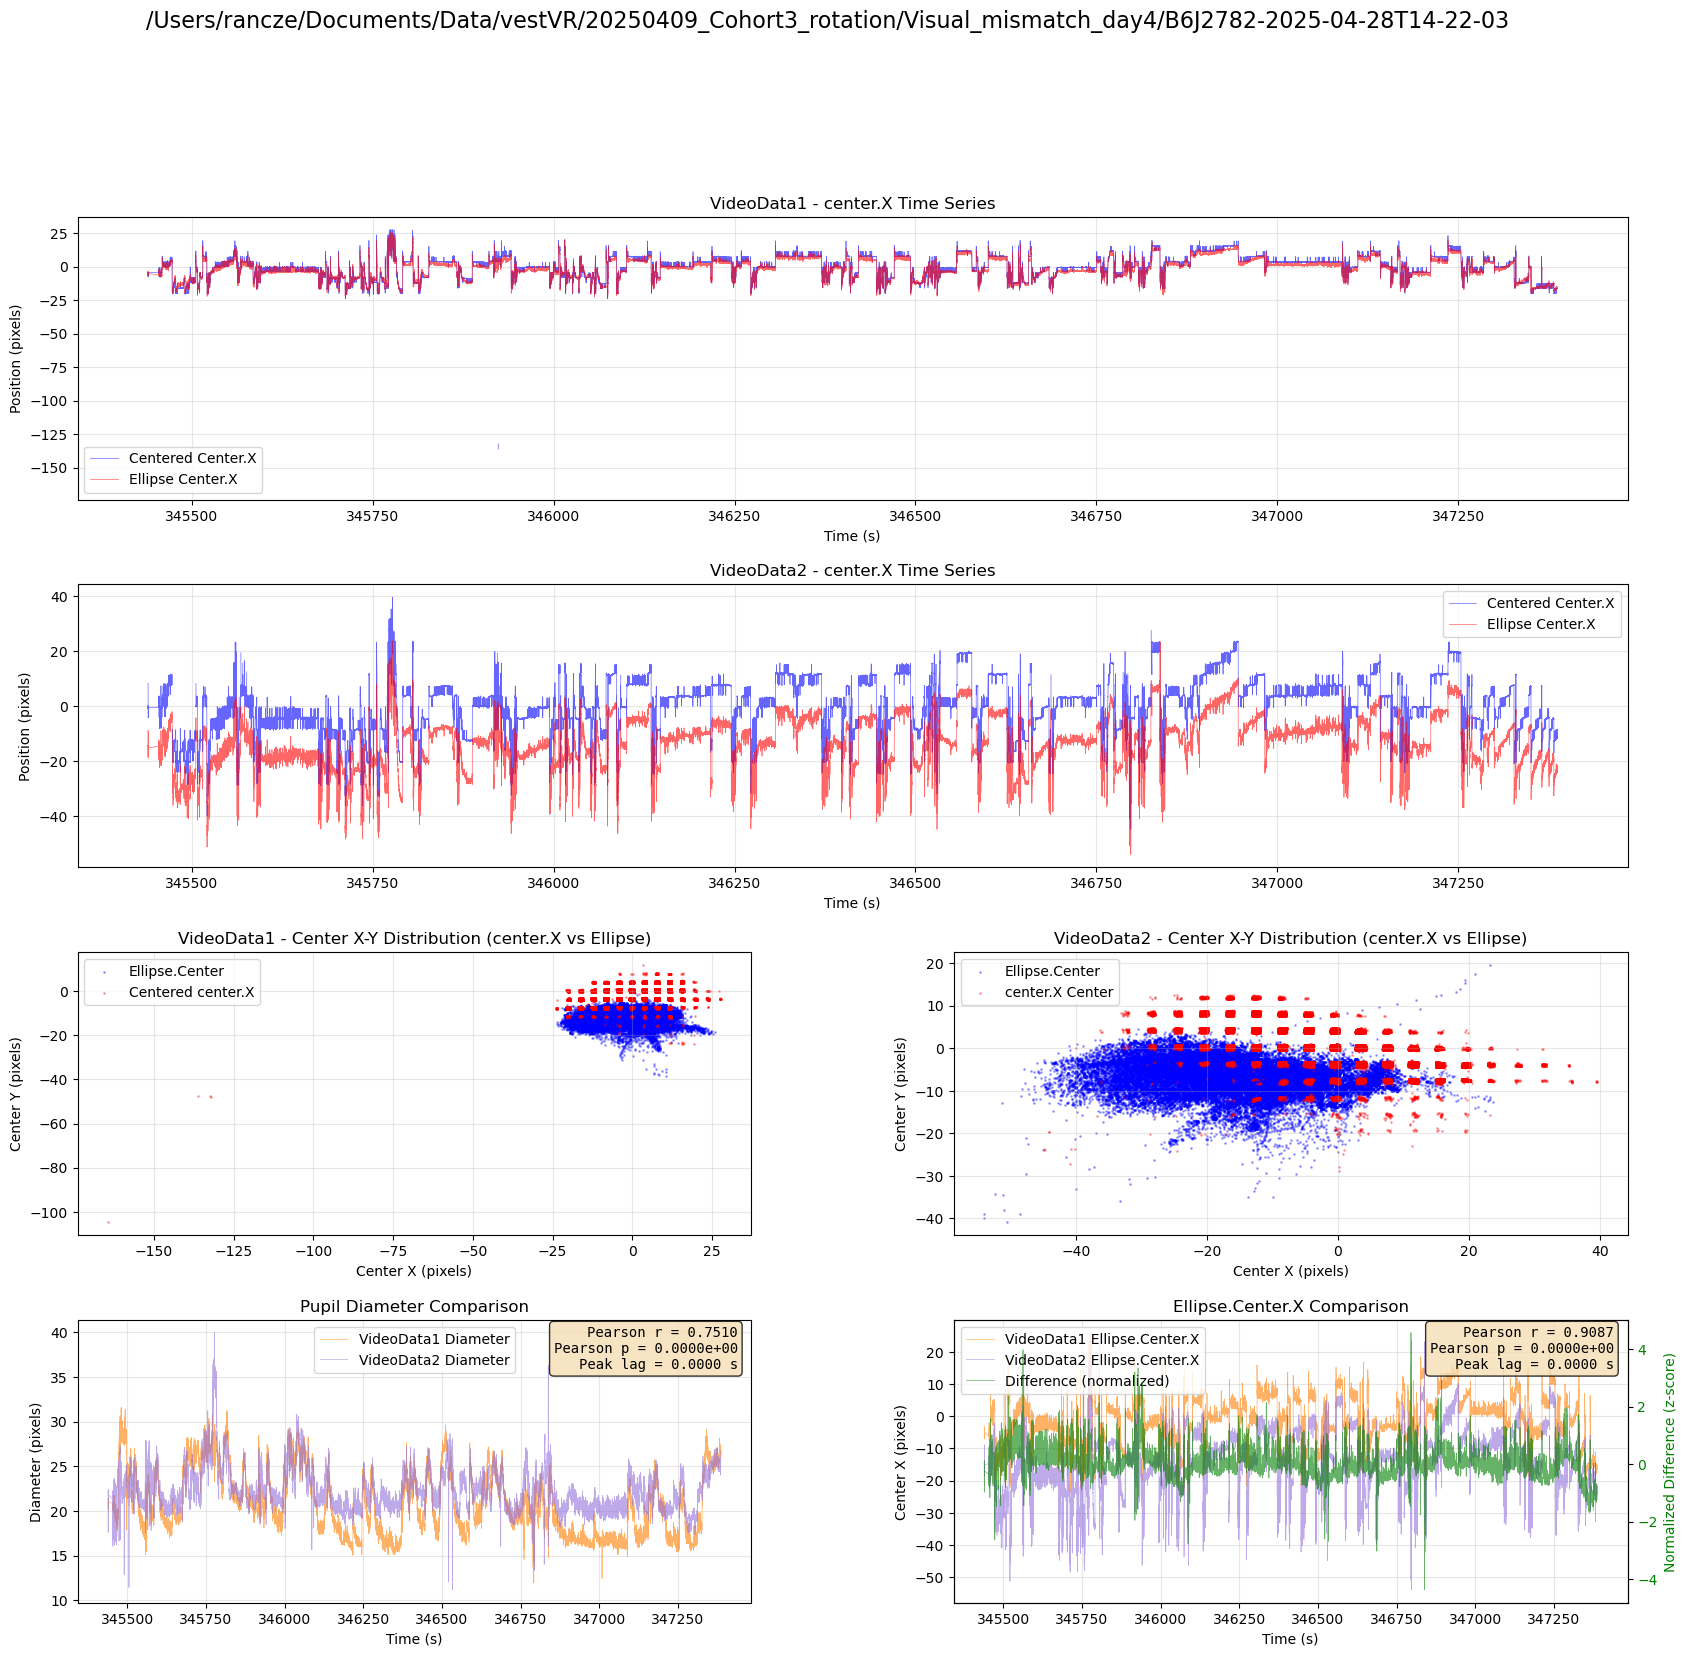

In [29]:
# Make and save summary QC plot using matplotlib with scatter plots for 2D distributions

# Initialize the statistics variables (these are calculated in Cell 11)
try:
    pearson_r_display
except NameError:
    pearson_r_display = None
    pearson_p_display = None
    peak_lag_time_display = None
    print("⚠️ Note: Statistics not found. They should be calculated in Cell 11.")

# Calculate correlation for Ellipse.Center.X between VideoData1 and VideoData2 (if both exist)
pearson_r_center = None
pearson_p_center = None
peak_lag_time_center = None

if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # Get the Center.X data
    center_x1 = VideoData1['Ellipse.Center.X'].values
    center_x2 = VideoData2['Ellipse.Center.X'].values
    
    min_length = min(len(center_x1), len(center_x2))
    center_x1_truncated = center_x1[:min_length]
    center_x2_truncated = center_x2[:min_length]
    
    valid_mask1 = ~np.isnan(center_x1_truncated)
    valid_mask2 = ~np.isnan(center_x2_truncated)
    valid_mask = valid_mask1 & valid_mask2
    
    center_x1_clean = center_x1_truncated[valid_mask]
    center_x2_clean = center_x2_truncated[valid_mask]
    
    if len(center_x1_clean) >= 2 and len(center_x2_clean) >= 2:
        try:
            # Calculate Pearson correlation
            pearson_r_center, pearson_p_center = pearsonr(center_x1_clean, center_x2_clean)
            
            # Calculate cross-correlation for peak lag
            correlation = correlate(center_x1_clean, center_x2_clean, mode='full')
            lags = np.arange(-len(center_x2_clean) + 1, len(center_x1_clean))
            dt = np.median(np.diff(VideoData1['Seconds']))
            lag_times = lags * dt
            peak_idx = np.argmax(correlation)
            peak_lag_time_center = lag_times[peak_idx]
        except Exception as e:
            print(f"❌ Error calculating Ellipse.Center.X correlation stats: {e}")

# Create the QC summary figure using matplotlib with custom grid layout
fig = plt.figure(figsize=(20, 18))
fig.suptitle(str(data_path), fontsize=16, y=0.995)

# Create a grid layout:
# - Top row (full width): VideoData1 Time Series
# - Second row (full width): VideoData2 Time Series  
# - Third row (two columns): 2D scatter plots (VideoData1 left, VideoData2 right)
# - Fourth row (two columns): Pupil diameter (left), Ellipse.Center.X correlation (right)

gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# Panel 1: VideoData1 center coordinates - Time Series (full width)
if VideoData1_Has_Sleap:
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(VideoData1_centered['Seconds'], VideoData1_centered['center.x'],
            linewidth=0.5, c='blue', alpha=0.6, label='Centered Center.X')
    ax1.plot(VideoData1['Seconds'], VideoData1['Ellipse.Center.X'],
            linewidth=0.5, c='red', alpha=0.6, label='Ellipse Center.X')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (pixels)')
    ax1.set_title('VideoData1 - center.X Time Series')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Panel 2: VideoData2 center coordinates - Time Series (full width)
if VideoData2_Has_Sleap:
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(VideoData2_centered['Seconds'], VideoData2_centered['center.x'],
            linewidth=0.5, c='blue', alpha=0.6, label='Centered Center.X')
    ax2.plot(VideoData2['Seconds'], VideoData2['Ellipse.Center.X'],
            linewidth=0.5, c='red', alpha=0.6, label='Ellipse Center.X')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Position (pixels)')
    ax2.set_title('VideoData2 - center.X Time Series')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Panel 3: VideoData1 center coordinates - Scatter plot (left half)
if VideoData1_Has_Sleap:
    ax3 = fig.add_subplot(gs[2, 0])
    
    # Ellipse.Center (blue)
    x_ellipse1 = VideoData1['Ellipse.Center.X'].to_numpy()
    y_ellipse1 = VideoData1['Ellipse.Center.Y'].to_numpy()
    mask1 = ~(np.isnan(x_ellipse1) | np.isnan(y_ellipse1))
    
    ax3.scatter(x_ellipse1[mask1], y_ellipse1[mask1],
               s=1, alpha=0.3, c='blue', label='Ellipse.Center')
    
    # Center (red) - from centered data
    x_center1 = VideoData1_centered['center.x'].to_numpy()
    y_center1 = VideoData1_centered['center.y'].to_numpy()
    mask2 = ~(np.isnan(x_center1) | np.isnan(y_center1))
    
    ax3.scatter(x_center1[mask2], y_center1[mask2],
               s=1, alpha=0.3, c='red', label='Centered center.X')
    
    ax3.set_xlabel('Center X (pixels)')
    ax3.set_ylabel('Center Y (pixels)')
    ax3.set_title('VideoData1 - Center X-Y Distribution (center.X vs Ellipse)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# Panel 4: VideoData2 center coordinates - Scatter plot (right half)
if VideoData2_Has_Sleap:
    ax4 = fig.add_subplot(gs[2, 1])
    
    # Ellipse.Center (blue)
    x_ellipse2 = VideoData2['Ellipse.Center.X'].to_numpy()
    y_ellipse2 = VideoData2['Ellipse.Center.Y'].to_numpy()
    mask3 = ~(np.isnan(x_ellipse2) | np.isnan(y_ellipse2))
    
    ax4.scatter(x_ellipse2[mask3], y_ellipse2[mask3],
               s=1, alpha=0.3, c='blue', label='Ellipse.Center')
    
    # Center (red) - from centered data
    x_center2 = VideoData2_centered['center.x'].to_numpy()
    y_center2 = VideoData2_centered['center.y'].to_numpy()
    mask4 = ~(np.isnan(x_center2) | np.isnan(y_center2))
    
    ax4.scatter(x_center2[mask4], y_center2[mask4],
               s=1, alpha=0.3, c='red', label='center.X Center')
    
    ax4.set_xlabel('Center X (pixels)')
    ax4.set_ylabel('Center Y (pixels)')
    ax4.set_title('VideoData2 - Center X-Y Distribution (center.X vs Ellipse)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# Panel 5: Pupil diameter comparison (bottom left)
ax5 = fig.add_subplot(gs[3, 0])
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    ax5.plot(VideoData1['Seconds'], VideoData1['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Diameter')
    ax5.plot(VideoData2['Seconds'], VideoData2['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Diameter')
elif VideoData1_Has_Sleap:
    ax5.plot(VideoData1['Seconds'], VideoData1['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Diameter')
elif VideoData2_Has_Sleap:
    ax5.plot(VideoData2['Seconds'], VideoData2['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Diameter')

ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Diameter (pixels)')
ax5.set_title('Pupil Diameter Comparison')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Add statistics text to Panel 5
if pearson_r_display is not None and pearson_p_display is not None and peak_lag_time_display is not None:
    stats_text = (f'Pearson r = {pearson_r_display:.4f}\n'
                  f'Pearson p = {pearson_p_display:.4e}\n'
                  f'Peak lag = {peak_lag_time_display:.4f} s')
    ax5.text(0.98, 0.98, stats_text, transform=ax5.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10, family='monospace')
else:
    ax5.text(0.5, 0.5, 'Statistics not available\n(See Cell 11 for correlation analysis)', 
            transform=ax5.transAxes, ha='center', va='center', fontsize=10)

# Panel 6: Ellipse.Center.X comparison (bottom right) with dual y-axis
ax6 = fig.add_subplot(gs[3, 1])
ax6_twin = ax6.twinx()  # Create a second y-axis

if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # Plot the individual traces
    ax6.plot(VideoData1['Seconds'], VideoData1['Ellipse.Center.X'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Ellipse.Center.X')
    ax6.plot(VideoData2['Seconds'], VideoData2['Ellipse.Center.X'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Ellipse.Center.X')
    
    # Plot the difference on the right axis
    # Align the data to the same length and normalize for fair comparison
    min_length = min(len(VideoData1), len(VideoData2))
    
    # Normalize data (z-score) to account for different scales
    center_x1_aligned = VideoData1['Ellipse.Center.X'].iloc[:min_length]
    center_x2_aligned = VideoData2['Ellipse.Center.X'].iloc[:min_length]
    
    # Calculate mean and std for normalization
    mean1 = center_x1_aligned.mean()
    std1 = center_x1_aligned.std()
    mean2 = center_x2_aligned.mean()
    std2 = center_x2_aligned.std()
    
    # Normalize both datasets
    center_x1_norm = (center_x1_aligned - mean1) / std1
    center_x2_norm = (center_x2_aligned - mean2) / std2
    
    # Calculate difference of normalized data
    center_x_diff = center_x1_norm - center_x2_norm
    seconds_aligned = VideoData1['Seconds'].iloc[:min_length]
    ax6_twin.plot(seconds_aligned, center_x_diff,
                  linewidth=0.5, c='green', alpha=0.6, label='Difference (normalized)')
    
elif VideoData1_Has_Sleap:
    ax6.plot(VideoData1['Seconds'], VideoData1['Ellipse.Center.X'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Ellipse.Center.X')
elif VideoData2_Has_Sleap:
    ax6.plot(VideoData2['Seconds'], VideoData2['Ellipse.Center.X'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Ellipse.Center.X')

ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Center X (pixels)', color='black')
ax6.set_title('Ellipse.Center.X Comparison')
ax6.tick_params(axis='y', labelcolor='black')
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    ax6_twin.set_ylabel('Normalized Difference (z-score)', color='green')
    ax6_twin.tick_params(axis='y', labelcolor='green')

# Combine legends from both axes
lines1, labels1 = ax6.get_legend_handles_labels()
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    lines2, labels2 = ax6_twin.get_legend_handles_labels()
    ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
else:
    ax6.legend(loc='upper left')

ax6.grid(True, alpha=0.3)

# Add statistics text to Panel 6
if pearson_r_center is not None and pearson_p_center is not None and peak_lag_time_center is not None:
    stats_text = (f'Pearson r = {pearson_r_center:.4f}\n'
                  f'Pearson p = {pearson_p_center:.4e}\n'
                  f'Peak lag = {peak_lag_time_center:.4f} s')
    ax6.text(0.98, 0.98, stats_text, transform=ax6.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10, family='monospace')
else:
    ax6.text(0.5, 0.5, 'Statistics not available\n(both eyes required)', 
            transform=ax6.transAxes, ha='center', va='center', fontsize=10)

# Save as PDF
save_path.mkdir(parents=True, exist_ok=True)
pdf_path = save_path / "Eye_data_QC.pdf"
plt.savefig(pdf_path, dpi=300, bbox_inches='tight', format='pdf')
print(f"✅ QC figure saved to: {pdf_path}")

plt.show()


In [30]:
# Create interactive time series plots using plotly for browser viewing

# Create subplots for the time series (3 rows now instead of 2)
# Need to enable secondary_y for the third panel
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=('VideoData1 - center.X Time Series', 
                    'VideoData2 - center.X Time Series',
                    'Ellipse.Center.X Comparison with Difference'),
    specs=[[{}], [{}], [{"secondary_y": True}]]  # Enable secondary_y for row 3
)

# Panel 1: VideoData1 center coordinates - Time Series
if VideoData1_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData1_centered['Seconds'],
        y=VideoData1_centered['center.x'],
        mode='lines',
        name='Centered Center.X',
        line=dict(color='blue', width=0.5),
        opacity=0.6
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=VideoData1['Seconds'],
        y=VideoData1['Ellipse.Center.X'],
        mode='lines',
        name='Ellipse Center.X',
        line=dict(color='red', width=0.5),
        opacity=0.6
    ), row=1, col=1)

# Panel 2: VideoData2 center coordinates - Time Series
if VideoData2_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData2_centered['Seconds'],
        y=VideoData2_centered['center.x'],
        mode='lines',
        name='Centered Center.X',
        line=dict(color='blue', width=0.5),
        opacity=0.6
    ), row=2, col=1)
    
    fig.add_trace(go.Scatter(
        x=VideoData2['Seconds'],
        y=VideoData2['Ellipse.Center.X'],
        mode='lines',
        name='Ellipse Center.X',
        line=dict(color='red', width=0.5),
        opacity=0.6
    ), row=2, col=1)

# Panel 3: Ellipse.Center.X Comparison with difference
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # Plot the individual traces
    fig.add_trace(go.Scatter(
        x=VideoData1['Seconds'],
        y=VideoData1['Ellipse.Center.X'],
        mode='lines',
        name='VideoData1 Ellipse.Center.X',
        line=dict(color='#FF7F00', width=0.5),  # Orange
        opacity=0.6
    ), row=3, col=1)
    
    fig.add_trace(go.Scatter(
        x=VideoData2['Seconds'],
        y=VideoData2['Ellipse.Center.X'],
        mode='lines',
        name='VideoData2 Ellipse.Center.X',
        line=dict(color='#9370DB', width=0.5),  # Purple
        opacity=0.6
    ), row=3, col=1)
    
    # Plot the difference on secondary y-axis
    # Align the data to the same length and normalize for fair comparison
    min_length = min(len(VideoData1), len(VideoData2))
    
    # Normalize data (z-score) to account for different scales
    center_x1_aligned = VideoData1['Ellipse.Center.X'].iloc[:min_length]
    center_x2_aligned = VideoData2['Ellipse.Center.X'].iloc[:min_length]
    
    # Calculate mean and std for normalization
    mean1 = center_x1_aligned.mean()
    std1 = center_x1_aligned.std()
    mean2 = center_x2_aligned.mean()
    std2 = center_x2_aligned.std()
    
    # Normalize both datasets
    center_x1_norm = (center_x1_aligned - mean1) / std1
    center_x2_norm = (center_x2_aligned - mean2) / std2
    
    # Calculate difference of normalized data
    center_x_diff = center_x1_norm - center_x2_norm
    seconds_aligned = VideoData1['Seconds'].iloc[:min_length]
    
    fig.add_trace(go.Scatter(
        x=seconds_aligned,
        y=center_x_diff,
        mode='lines',
        name='Difference (normalized)',
        line=dict(color='green', width=0.5),
        opacity=0.6
    ), row=3, col=1, secondary_y=True)
    
elif VideoData1_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData1['Seconds'],
        y=VideoData1['Ellipse.Center.X'],
        mode='lines',
        name='VideoData1 Ellipse.Center.X',
        line=dict(color='#FF7F00', width=0.5),
        opacity=0.6
    ), row=3, col=1)
elif VideoData2_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData2['Seconds'],
        y=VideoData2['Ellipse.Center.X'],
        mode='lines',
        name='VideoData2 Ellipse.Center.X',
        line=dict(color='#9370DB', width=0.5),
        opacity=0.6
    ), row=3, col=1)

# Update layout
fig.update_layout(
    height=1200,  # Increased height for 3 panels
    title_text=f'{data_path} - Eye Tracking Time Series QC',
    showlegend=True,
    hovermode='x unified'
)

# Update axes
fig.update_xaxes(title_text="Time (s)", row=3, col=1)
fig.update_yaxes(title_text="Position (pixels)", row=1, col=1)
fig.update_yaxes(title_text="Position (pixels)", row=2, col=1)
fig.update_yaxes(title_text="Center X (pixels)", row=3, col=1)

# Update secondary y-axis for difference plot
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    fig.update_yaxes(title_text="Normalized Difference (z-score)", row=3, col=1, secondary_y=True)

# Show in browser
fig.show(renderer='browser')

# Also save as HTML
save_path.mkdir(parents=True, exist_ok=True)
html_path = save_path / "Eye_data_QC_time_series.html"
fig.write_html(html_path)
print(f"✅ Interactive time series plot saved to: {html_path}")


✅ Interactive time series plot saved to: /Users/rancze/Documents/Data/vestVR/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2782-2025-04-28T14-22-03_processedData/Eye_data_QC_time_series.html


In [ ]:
# save as df to csv to be loaded in the photometry/harp/etc. analysis notebook 
############################################################################################################
# reindex to aeon datetime to be done in the other notebook
 
if VideoData1_Has_Sleap:
    # Save  DataFrame as CSV to proper path and filename
    save_path1 = save_path / "Video_Sleap_Data1" / "Video_Sleap_Data1_1904-01-01T00-00-00.csv"
    save_path1.parent.mkdir(parents=True, exist_ok=True)
    #save_path1.parent.mkdir(parents=True, exist_ok=True)
    VideoData1.to_csv(save_path1)

if VideoData2_Has_Sleap:
    # Save  DataFrame as CSV to proper path and filename
    save_path2 = save_path / "Video_Sleap_Data2" / "Video_Sleap_Data2_1904-01-01T00-00-00.csv"
    save_path2.parent.mkdir(parents=True, exist_ok=True)
    #save_path2.parent.mkdir(parents=True, exist_ok=True)
    VideoData2.to_csv(save_path2)


# Saccade detection


In [ ]:
VideoData1[["Seconds", "Ellipse.Center.X"]].head

In [ ]:
# 1. Preprocess:  smooth
df = VideoData1[["Ellipse.Center.X", "Seconds"]].copy()

df['X_smooth'] = (
    df['Ellipse.Center.X']
      .rolling(window=5, center=True)
      .median()
      .bfill()
      .ffill()
)

# 2. Compute instantaneous velocity
#   dt in seconds
df['dt'] = df['Seconds'].diff()
#   vel = dX / dt
df['vel_x'] = df['X_smooth'].diff() / df['dt']

# --- Plot smoothed trace and on separate y axis plot velocity---
# Create subplots with shared x-axis for synchronized zooming
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,  # This ensures x-axis zoom synchronization
    vertical_spacing=0.1,
    subplot_titles=('X Position (px)', 'Velocity (px/s)')
)

# Add X_smooth to the first subplot
fig.add_trace(
    go.Scatter(
        x=df['Seconds'],
        y=df['X_smooth'],
        mode='lines',
        name='Smoothed X',
        line=dict(color='blue')
    ),
    row=1, col=1
)

# Add velocity to the second subplot
fig.add_trace(
    go.Scatter(
        x=df['Seconds'],
        y=df['vel_x'],
        mode='lines',
        name='Velocity',
        line=dict(color='red')
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    title='Smoothed X and Velocity Traces (Synchronized Zoom)',
    height=600,  # Adjust height for two subplots
    showlegend=True,
    legend=dict(x=0.01, y=0.99)
)

# Update x-axes
fig.update_xaxes(title_text="Time (s)", row=2, col=1)

# Update y-axes
fig.update_yaxes(title_text="X Position (px)", row=1, col=1)
fig.update_yaxes(title_text="Velocity (px/s)", row=2, col=1)

fig.show()

# more complex approach 

In [ ]:
def detect_saccades_refined(df, k=3, pct=0.2, refractory=0.100):
    """
    df must have columns: Seconds, X_smooth, vel_x.
    Returns DataFrame with one row per saccade:
      start_time, end_time, peak_vel, amplitude, direction
    """
    # 1) compute global thresholds
    abs_vel = df['vel_x'].abs().dropna()
    vel_thresh = abs_vel.mean() + k * abs_vel.std()
    pos_thresh, neg_thresh =  vel_thresh, -vel_thresh

    # 2) label rough segments
    df = df.copy()
    df['is_pos'] = df['vel_x'] > pos_thresh
    df['is_neg'] = df['vel_x'] < neg_thresh

    df['id_pos'] = (df['is_pos'] & ~df['is_pos'].shift(fill_value=False)).cumsum().where(df['is_pos'], 0)
    df['id_neg'] = (df['is_neg'] & ~df['is_neg'].shift(fill_value=False)).cumsum().where(df['is_neg'], 0)

    events = []
    for direction, seg_id_col, thr in [
        ('pos','id_pos', pos_thresh),
        ('neg','id_neg', neg_thresh)
    ]:
        for seg_id, seg in df.groupby(seg_id_col):
            if seg_id == 0: 
                continue

            t = seg['Seconds'].values
            v = seg['vel_x'].values
            # a) raw indices of first crossing
            #    (we know seg[0] is already above thr)
            #    so look for the first index i where v[i] > thr (or < thr)
            if direction=='pos':
                idx_cross = np.nonzero(v > thr)[0][0]
            else:
                idx_cross = np.nonzero(v < thr)[0][0]

            # b) interpolate to find sub-sample start crossing
            if idx_cross>0:
                t0, v0 = t[idx_cross-1], v[idx_cross-1]
                t1, v1 = t[idx_cross],   v[idx_cross]
                t_start_rough = t0 + (thr - v0)*(t1-t0)/(v1-v0)
            else:
                # already above threshold at first sample
                t_start_rough = t[0]

            # c) find the peak (or plateau) within this segment
            if direction=='pos':
                peak_i = np.argmax(v)
            else:
                peak_i = np.argmin(v)
            v_peak = v[peak_i]

            # d) define 20%-of-peak threshold (preserve sign)
            thr20 = pct * abs(v_peak) * np.sign(v_peak)

            # e) find raw end: first idx after peak where |v| < |thr20|
            after_peak = np.where(np.abs(v[peak_i:]) < abs(thr20))[0]
            if len(after_peak)==0:
                # didn’t return to baseline within segment—skip
                continue
            idx_end = peak_i + after_peak[0]

            # f) interpolate to get sub-sample end time
            if idx_end>0:
                t0_e, v0_e = t[idx_end-1], v[idx_end-1]
                t1_e, v1_e = t[idx_end],   v[idx_end]
                t_end = t0_e + (thr20 - v0_e)*(t1_e-t0_e)/(v1_e-v0_e)
            else:
                t_end = t[0]

            # g) walk backwards from peak to find when |v| last < |thr20|
            before_peak = np.where(np.abs(v[:peak_i][::-1]) < abs(thr20))[0]
            if len(before_peak)==0:
                # can’t find a clean baseline before peak → use rough start
                t_start = t_start_rough
            else:
                j = peak_i - before_peak[0]  # this is first index > thr20 going backward
                # j-1 is last below-thr20
                t0_s, v0_s = t[j-1], v[j-1]
                t1_s, v1_s = t[j],   v[j]
                t_start = t0_s + (thr20 - v0_s)*(t1_s-t0_s)/(v1_s-v0_s)

            # h) compute amplitude using interpolation of X_smooth
            X = df[['Seconds','X_smooth']].dropna()
            amp = np.interp(t_end,   X['Seconds'], X['X_smooth']) \
                - np.interp(t_start, X['Seconds'], X['X_smooth'])

            events.append({
                'start_time': t_start,
                'end_time':   t_end,
                'peak_vel':   v_peak,
                'amplitude':  amp,
                'direction':  direction
            })

    # 3) make DataFrame & apply refractory
    sacc = pd.DataFrame(events).sort_values('start_time').reset_index(drop=True)

    keep = []
    last_end = -np.inf
    for _, row in sacc.iterrows():
        if row['start_time'] - last_end >= refractory:
            keep.append(row)
            last_end = row['end_time']
    return pd.DataFrame(keep)


# ——————————————————————————————
# USAGE:
sacc_refined = detect_saccades_refined(df, k=3, pct=0.4, refractory=0.100)
print(sacc_refined)

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ── 1) Define window and subset ───────────────────────────────
t0_rel, t1_rel = 0, 1600
t0 = df['Seconds'].min() + t0_rel
t1 = df['Seconds'].min() + t1_rel

df_win = df[(df['Seconds'] >= t0) & (df['Seconds'] <= t1)]
s = sacc_refined[
    (sacc_refined['start_time'] >= t0) &
    (sacc_refined['end_time']   <= t1)
]

# ── 2) Interpolate to get X_smooth & vel_x at exact start/end ──
x_start = np.interp(s['start_time'], df_win['Seconds'], df_win['X_smooth'])
x_end   = np.interp(s['end_time'],   df_win['Seconds'], df_win['X_smooth'])
v_start = np.interp(s['start_time'], df_win['Seconds'], df_win['vel_x'])
v_end   = np.interp(s['end_time'],   df_win['Seconds'], df_win['vel_x'])

# ── 3) Build 2-row subplot (shared x-axis) ────────────────────
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.6,0.4],
    subplot_titles=("Position (px)", "Velocity (px/s)")
)

# Position trace
fig.add_trace(go.Scattergl(
    x=df_win['Seconds'], y=df_win['X_smooth'],
    mode='lines', line=dict(width=1), name='Position'
), row=1, col=1)

# Position: start markers
fig.add_trace(go.Scattergl(
    x=s['start_time'], y=x_start,
    mode='markers',
    marker=dict(symbol='triangle-up', size=8, color='red'),
    name='Sac start'
), row=1, col=1)

# Position: end markers
fig.add_trace(go.Scattergl(
    x=s['end_time'], y=x_end,
    mode='markers',
    marker=dict(symbol='triangle-down', size=8, color='blue'),
    name='Sac end'
), row=1, col=1)


# Velocity trace
fig.add_trace(go.Scattergl(
    x=df_win['Seconds'], y=df_win['vel_x'],
    mode='lines', line=dict(width=1), name='Velocity'
), row=2, col=1)

# Velocity: start markers (hide legend duplicates)
fig.add_trace(go.Scattergl(
    x=s['start_time'], y=v_start,
    mode='markers',
    marker=dict(symbol='triangle-up', size=8, color='red'),
    showlegend=False
), row=2, col=1)

# Velocity: end markers
fig.add_trace(go.Scattergl(
    x=s['end_time'], y=v_end,
    mode='markers',
    marker=dict(symbol='triangle-down', size=8, color='blue'),
    showlegend=False
), row=2, col=1)


# ── 4) Layout tweaks ────────────────────────────────────────────
fig.update_layout(
    title=f"QC: {t0_rel}–{t1_rel} s Window",
    height=500,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    margin=dict(l=50, r=50, t=60, b=40),
)

# shared x-axis formatting
fig.update_xaxes(title_text="Time (s)", range=[t0, t1], row=2, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)

fig.show()

# simple approach

In [ ]:
# 1. Compute symmetric thresholds
abs_vel = df['vel_x'].abs().dropna()
k = 3  # times std to use as threshold
vel_thresh = abs_vel.mean() + k * abs_vel.std()
pos_thresh =  vel_thresh
neg_thresh = -vel_thresh
print(f"pos_thresh = {pos_thresh:.1f}, neg_thresh = {neg_thresh:.1f} px/s")

# 2. Masks for each direction
df['is_sac_pos'] = df['vel_x'] > pos_thresh
df['is_sac_neg'] = df['vel_x'] < neg_thresh

# 3. Label contiguous runs
df['sac_pos_id'] = (
    (df['is_sac_pos'] & ~df['is_sac_pos'].shift(fill_value=False))
    .cumsum()
    .where(df['is_sac_pos'], 0)
)
df['sac_neg_id'] = (
    (df['is_sac_neg'] & ~df['is_sac_neg'].shift(fill_value=False))
    .cumsum()
    .where(df['is_sac_neg'], 0)
)

# 4. Aggregate each into summaries, then concat
def summarize(df, col_id, direction):
    return (
        df[df[col_id] > 0]
        .groupby(col_id)
        .agg(
            start_time=('Seconds', 'first'),
            end_time  =('Seconds', 'last'),
            peak_vel  =('vel_x', lambda x: x.max() if direction=='pos' else x.min()),
            amplitude =('X_smooth', lambda x: (x.max()-x.min()) if direction=='pos' else (x.min()-x.max()))
        )
        .assign(direction=direction)
    )

sac_pos = summarize(df, 'sac_pos_id', 'pos')
sac_neg = summarize(df, 'sac_neg_id', 'neg')

saccades = pd.concat([sac_pos, sac_neg], ignore_index=True)
print(f"Detected {len(saccades)} saccades ({sac_pos.shape[0]} pos, {sac_neg.shape[0]} neg)")

# Add a refractory period of 100 ms to saccade detection
refractory_period = 0.100  # seconds (100 ms)

# Sort saccades by start_time just in case
saccades = saccades.sort_values('start_time').reset_index(drop=True)

# Keep only saccades that are at least 100 ms apart
filtered_saccades = []
last_end_time = -np.inf

for idx, row in saccades.iterrows():
    if row['start_time'] - last_end_time >= refractory_period:
        filtered_saccades.append(row)
        last_end_time = row['end_time']

filtered_saccades = pd.DataFrame(filtered_saccades)
print(f"After applying 100 ms refractory period: {len(filtered_saccades)} saccades remain")


In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1) Define window and subset
t0_rel, t1_rel = 0, 1800
t0 = df['Seconds'].min() + t0_rel
t1 = df['Seconds'].min() + t1_rel

df_win = df[(df['Seconds'] >= t0) & (df['Seconds'] <= t1)]
sacs_win = filtered_saccades[
    (filtered_saccades['start_time'] >= t0) &
    (filtered_saccades['start_time'] <= t1)
]

pos = sacs_win[sacs_win['direction']=='pos']
neg = sacs_win[sacs_win['direction']=='neg']

# Pre‐compute the X_smooth at each saccade start for the position markers
x_pos_starts = np.interp(pos['start_time'], df_win['Seconds'], df_win['X_smooth'])
x_neg_starts = np.interp(neg['start_time'], df_win['Seconds'], df_win['X_smooth'])

# 2) Build 2-row subplot
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.6, 0.4],
    subplot_titles=("Position (px)", "Velocity (px/s)")
)

# 3) Position trace + saccade markers
fig.add_trace(
    go.Scattergl(
        x=df_win['Seconds'],
        y=df_win['X_smooth'],
        mode='lines',
        line=dict(width=1),
        name='Position'
    ),
    row=1, col=1
)
# Pos saccade starts on pos plot
fig.add_trace(
    go.Scattergl(
        x=pos['start_time'],
        y=x_pos_starts,
        mode='markers',
        marker=dict(symbol='triangle-up', size=8, color='red'),
        showlegend=False
    ),
    row=1, col=1
)
# Neg saccade starts on pos plot
fig.add_trace(
    go.Scattergl(
        x=neg['start_time'],
        y=x_neg_starts,
        mode='markers',
        marker=dict(symbol='triangle-down', size=8, color='blue'),
        showlegend=False
    ),
    row=1, col=1
)

# 4) Velocity trace + saccade markers
fig.add_trace(
    go.Scattergl(
        x=df_win['Seconds'],
        y=df_win['vel_x'],
        mode='lines',
        line=dict(width=1),
        name='Velocity'
    ),
    row=2, col=1
)
# Pos saccade starts on vel plot
fig.add_trace(
    go.Scattergl(
        x=pos['start_time'],
        y=[pos_thresh]*len(pos),
        mode='markers',
        marker=dict(symbol='triangle-up', size=8, color='red'),
        name='Pos sacc start'
    ),
    row=2, col=1
)
# Neg saccade starts on vel plot
fig.add_trace(
    go.Scattergl(
        x=neg['start_time'],
        y=[neg_thresh]*len(neg),
        mode='markers',
        marker=dict(symbol='triangle-down', size=8, color='blue'),
        name='Neg sacc start'
    ),
    row=2, col=1
)

# 5) Layout
fig.update_layout(
    title=f"QC: {t0_rel}–{t1_rel} s Window",
    height=500,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    margin=dict(l=50, r=50, t=60, b=40),
)

# 6) X‐axis formatting
fig.update_xaxes(title_text="Time (s)", range=[t0, t1], row=2, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)

fig.show()

In [ ]:
from scipy import stats

# ══════════════════════════════════════════════════════════════════════════════════
# ROBUST SACCADE THRESHOLD DETERMINATION
# ══════════════════════════════════════════════════════════════════════════════════

# 1. ANALYZE VELOCITY DISTRIBUTION
vel_abs = np.abs(df['vel_x'].dropna())

# Basic statistics
vel_mean = np.mean(vel_abs)
vel_median = np.median(vel_abs)
vel_std = np.std(vel_abs)
vel_mad = stats.median_abs_deviation(vel_abs)  # More robust than std

print(f"Velocity Statistics:")
print(f"Mean absolute velocity: {vel_mean:.2f} px/s")
print(f"Median absolute velocity: {vel_median:.2f} px/s")
print(f"Standard deviation: {vel_std:.2f} px/s")
print(f"Median Absolute Deviation (MAD): {vel_mad:.2f} px/s")

# 2. MULTIPLE THRESHOLD APPROACHES
# Approach A: Standard deviation based (classical)
threshold_std_3 = vel_mean + 3 * vel_std
threshold_std_4 = vel_mean + 4 * vel_std
threshold_std_5 = vel_mean + 5 * vel_std

# Approach B: MAD-based (more robust to outliers)
threshold_mad_3 = vel_median + 3 * vel_mad
threshold_mad_4 = vel_median + 4 * vel_mad
threshold_mad_5 = vel_median + 5 * vel_mad

# Approach C: Percentile-based
threshold_p95 = np.percentile(vel_abs, 95)
threshold_p97 = np.percentile(vel_abs, 97)
threshold_p99 = np.percentile(vel_abs, 99)

# Approach D: Otsu's method (automatic threshold selection)
def otsu_threshold(data, n_bins=512):
    """Find optimal threshold using Otsu's method"""
    hist, bin_edges = np.histogram(data, bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Normalize histogram
    hist = hist.astype(float) / hist.sum()
    
    # Calculate cumulative sums
    cum_sum = np.cumsum(hist)
    cum_mean = np.cumsum(hist * bin_centers)
    
    # Calculate between-class variance
    total_mean = cum_mean[-1]
    between_var = np.zeros_like(cum_sum)
    
    for i in range(len(cum_sum)):
        if cum_sum[i] > 0 and cum_sum[i] < 1:
            w0 = cum_sum[i]
            w1 = 1 - w0
            mu0 = cum_mean[i] / w0 if w0 > 0 else 0
            mu1 = (total_mean - cum_mean[i]) / w1 if w1 > 0 else 0
            between_var[i] = w0 * w1 * (mu0 - mu1) ** 2
    
    # Find threshold that maximizes between-class variance
    optimal_idx = np.argmax(between_var)
    return bin_centers[optimal_idx]

threshold_otsu = otsu_threshold(vel_abs)

# 3. DISPLAY ALL THRESHOLDS
print(f"\nProposed Thresholds:")
print(f"Standard deviation based:")
print(f"  3σ: {threshold_std_3:.2f} px/s")
print(f"  4σ: {threshold_std_4:.2f} px/s")
print(f"  5σ: {threshold_std_5:.2f} px/s")
print(f"MAD-based (robust):")
print(f"  3×MAD: {threshold_mad_3:.2f} px/s")
print(f"  4×MAD: {threshold_mad_4:.2f} px/s")
print(f"  5×MAD: {threshold_mad_5:.2f} px/s")
print(f"Percentile-based:")
print(f"  95th percentile: {threshold_p95:.2f} px/s")
print(f"  97th percentile: {threshold_p97:.2f} px/s")
print(f"  99th percentile: {threshold_p99:.2f} px/s")
print(f"Otsu's method: {threshold_otsu:.2f} px/s")

# 4. VISUALIZATION
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        'Velocity Distribution (Linear Scale)',
        'Velocity Distribution (Log Scale)', 
        'Cumulative Distribution',
        'Time Series with Threshold Candidates'
    ],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Plot 1: Histogram (linear)
fig.add_trace(
    go.Histogram(x=vel_abs, nbinsx=100, name='Velocity', opacity=0.7),
    row=1, col=1
)

# Add threshold lines
thresholds = {
    '3σ': threshold_std_3,
    '4σ': threshold_std_4, 
    '3×MAD': threshold_mad_3,
    '99th %ile': threshold_p99,
    'Otsu': threshold_otsu
}

colors = ['red', 'orange', 'blue', 'green', 'purple']
for i, (name, thresh) in enumerate(thresholds.items()):
    fig.add_vline(x=thresh, line_dash="dash", line_color=colors[i], 
                  annotation_text=f"{name}: {thresh:.1f}", row=1, col=1)

# Plot 2: Histogram (log scale)
fig.add_trace(
    go.Histogram(x=vel_abs, nbinsx=100, name='Velocity (log)', opacity=0.7),
    row=1, col=2
)
fig.update_yaxes(type="log", row=1, col=2)

# Plot 3: Cumulative distribution
sorted_vel = np.sort(vel_abs)
cumulative = np.arange(1, len(sorted_vel) + 1) / len(sorted_vel)
fig.add_trace(
    go.Scatter(x=sorted_vel, y=cumulative*100, mode='lines', name='CDF'),
    row=2, col=1
)

# Plot 4: Time series with threshold candidates
time_subset = df['Seconds'].iloc[::10]  # Subsample for visibility
vel_subset = np.abs(df['vel_x'].iloc[::10])

fig.add_trace(
    go.Scatter(x=time_subset, y=vel_subset, mode='lines', 
               name='|Velocity|', line=dict(color='lightgray')),
    row=2, col=2
)

for i, (name, thresh) in enumerate(thresholds.items()):
    fig.add_hline(y=thresh, line_dash="dash", line_color=colors[i],
                  annotation_text=f"{name}", row=2, col=2)

# Update layout
fig.update_layout(
    height=800,
    title_text="Saccade Threshold Analysis",
    showlegend=False
)

fig.update_xaxes(title_text="Absolute Velocity (px/s)", row=1, col=1)
fig.update_xaxes(title_text="Absolute Velocity (px/s)", row=1, col=2)
fig.update_xaxes(title_text="Absolute Velocity (px/s)", row=2, col=1)
fig.update_xaxes(title_text="Time (s)", row=2, col=2)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count (log)", row=1, col=2)
fig.update_yaxes(title_text="Cumulative %", row=2, col=1)
fig.update_yaxes(title_text="Velocity (px/s)", row=2, col=2)

fig.show()

# 5. RECOMMENDATION
print(f"\n🎯 RECOMMENDATIONS:")
print(f"1. For CONSERVATIVE detection (fewer false positives): Use 4-5σ or 4-5×MAD")
print(f"2. For SENSITIVE detection (catch more saccades): Use 3σ or 3×MAD")
print(f"3. For AUTOMATIC threshold: Use Otsu's method ({threshold_otsu:.1f} px/s)")
print(f"4. MAD-based thresholds are more robust to outliers than σ-based")
print(f"5. Consider your data characteristics and validation requirements")

# Suggested threshold (you can modify this logic)
if threshold_mad_3 > 20:  # Reasonable minimum for eye movements
    suggested_threshold = threshold_mad_3
    method_used = "3×MAD (robust)"
else:
    suggested_threshold = threshold_std_3
    method_used = "3σ (classical)"

print(f"\n✅ SUGGESTED THRESHOLD: {suggested_threshold:.1f} px/s ({method_used})")

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Add X_smooth (or X_interp) on primary y-axis
fig.add_trace(go.Scatter(
    x=df['Seconds'],
    y=df['X_smooth'],
    mode='lines',
    name='Smoothed X',
    line=dict(color='blue')
))

# Add velocity on secondary y-axis
fig.add_trace(go.Scatter(
    x=df['Seconds'],
    y=df['vel_x'],
    mode='lines',
    name='Velocity',
    line=dict(color='red'),
    yaxis='y2'
))

fig.update_layout(
    title='Smoothed X and Velocity Traces',
    xaxis_title='Time (s)',
    yaxis=dict(
        title='X Position (px)',
        title=dict(font=dict(color='blue')),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Velocity (px/s)',
        title=dict(font=dict(color='red')),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show(renderer='browser')

# PRE_ANR code

In [ ]:
# detect saccades 
df = VideoData1.copy()

df.index = pd.to_datetime(df.index * (1 / framerate), unit='s')

# 1) Compute velocity (units/s). Filter/diff/filter. Because sample rate is 1000 Hz, diff is * 1000.
window_size = int(round(2 / framerate * 1000))
df["velocity"] = df["Ellipse.Center.X"].rolling(window=window_size, center=True, min_periods=1).mean()
df["velocity"] = df["velocity"].diff() * 1000
window_size = int(round(4 / framerate * 1000))
df["velocity"] = df["velocity"].rolling(window=window_size, center=True, min_periods=1).mean()

# 2) Define a velocity threshold for saccades (adjust as needed)
# implement adaptive filter in the future 

# 3) Create a boolean mask for samples exceeding the threshold
df["is_saccade"] = df["velocity"].abs() > threshold

# 4) Group consecutive saccade samples to form saccade events.
#    Label each contiguous "True" block with a unique ID.
df["saccade_id"] = (df["is_saccade"] & ~df["is_saccade"].shift(fill_value=False)).cumsum() * df["is_saccade"]

# 5) Extract saccade onset times and basic details for each saccade.
saccade_events = []
for sacc_id, group in df.groupby("saccade_id"):
    if sacc_id == 0:
        continue
    saccade_time = group.index[0]
    peak_time = group["velocity"].abs().idxmax()  # Save the time when the absolute velocity peaks
    peak_velocity = group["velocity"].abs().max()
    direction = "positive" if group["velocity"].mean() > 0 else "negative"
    
    saccade_events.append({
        "saccade_id": sacc_id,
        "saccade_time": saccade_time,
        "peak_time": peak_time,         # New column for peak time
        "peak_velocity": peak_velocity,
        "direction": direction
    })

# 6) Apply a refractory period of 50 ms: if 2 saccade events occur within 50 ms, keep only the first.
filtered_saccade_events = []
last_event_time = None  # Initialize as None

for event in saccade_events:
    if last_event_time is None or (event["saccade_time"] - last_event_time) >= refractory_period:
        filtered_saccade_events.append(event)
        last_event_time = event["saccade_time"]


# 7) For each filtered saccade event, calculate the baseline and relative peak.
frame_duration = 1 / framerate  # seconds per frame
for event in filtered_saccade_events:
    saccade_time = event["saccade_time"]
    # Baseline: average the data for 3 frames immediately BEFORE the saccade onset.
    baseline_start = saccade_time - pd.Timedelta(seconds=3 * frame_duration)
    baseline = df.loc[baseline_start:saccade_time, "Ellipse.Center.X"].mean()
    event["baseline"] = baseline

    # Relative peak: in the next 40 ms after the saccade onset, measure the peak change relative to the baseline.
    window_end = saccade_time + pd.Timedelta(milliseconds=500)
    saccade_window = df.loc[saccade_time:window_end, "Ellipse.Center.X"]
    if event["direction"] == "positive":
        relative_peak = saccade_window.max() - baseline
    else:
        relative_peak = baseline - saccade_window.min()
    event["relative_peak"] = relative_peak

# Create a DataFrame of the filtered saccade events including the new metrics.
results_df = pd.DataFrame(filtered_saccade_events)


In [ ]:
if plot_saccade_detection_QC:
    pio.renderers.default = 'browser'
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df["velocity"], mode="lines", name="Velocity", line=dict(color="lightgrey", width=1)))
    fig.add_trace(go.Scatter(x=df.index, y=df["Ellipse.Center.X"], mode="lines", name="Ellipse.Center.X", line=dict(color="darkgrey", width=1), yaxis="y2"))
    if not results_df.empty:
        pos_df = results_df[results_df["direction"] == "positive"]
        neg_df = results_df[results_df["direction"] == "negative"]
        if not pos_df.empty:
            pos_starts = pos_df["saccade_time"]
            pos_y = df.loc[pos_starts, "Ellipse.Center.X"]
            fig.add_trace(go.Scatter(x=pos_starts, y=pos_y, mode="markers",
                                     marker=dict(symbol="circle-open", size=10, line=dict(width=2, color="red")),
                                     name="Positive Saccade Onsets", yaxis="y2"))
        if not neg_df.empty:
            neg_starts = neg_df["saccade_time"]
            neg_y = df.loc[neg_starts, "Ellipse.Center.X"]
            fig.add_trace(go.Scatter(x=neg_starts, y=neg_y, mode="markers",
                                     marker=dict(symbol="circle-open", size=10, line=dict(width=2, color="blue")),
                                     name="Negative Saccade Onsets", yaxis="y2"))
    fig.update_layout(
        title="Velocity and Ellipse.Center.X",
        xaxis_title="Time",
        yaxis=dict(title="Velocity"),
        yaxis2=dict(title="Ellipse.Center.X", overlaying="y", side="right")
    )
    fig.show()


In [ ]:
############################################################################################################
# INVESTIGATE issue of long stretches of consecutive very low inference predicition scores 
############################################################################################################


score_cutoff = 0.0000001
columns_of_interest = ['left.score','center.score','right.score','p1.score','p2.score','p3.score','p4.score','p5.score','p6.score','p7.score','p8.score']
total_points = len(VideoData1)


for col in columns_of_interest:
    count_below_threshold = (VideoData1[col] < score_cutoff).sum()
    percentage_below_threshold = (count_below_threshold / total_points) * 100
    
    # Find the longest consecutive series below threshold
    below_threshold = VideoData1[col] < score_cutoff
    longest_series = 0
    current_series = 0
    
    for value in below_threshold:
        if value:
            current_series += 1
            if current_series > longest_series:
                longest_series = current_series
        else:
            current_series = 0
    
    print(f"Column: {col} | Values below {score_cutoff}: {count_below_threshold} ({percentage_below_threshold:.2f}%) | Longest consecutive frame series: {longest_series}")


In [ ]:
pympler_memory_df = utils.get_pympler_memory_usage(top_n=10)